# Human Resources Analysis - Predicting Employee Attrition

By: Katrina James, Christian Urday, Justin Kerry

## Introductory Statement

Companies of all types have very specific processes for finding, screening, recruiting, and training job applicants. These processes are typically conducted by a division of the company known as Human Resources or "HR". This department of the company not only oversees the development of the the potential employees but it is also responsible for administering employee benefits programs, updating company knowledge of laws and bylaws, as well as firing employees when necessary.

Since Human Resources must be charged with the recruitment of employees, it would be very beneficial to the company to have a method of determining which employees will ultimately be lost through the natural process of attrition.

## Background

For our Course Project, we will be studying <b>Staff Attrition</b> not Staff Turnover.

- Staff Attrition is the loss of employees through a natural process <u>without the intention of filling the vacancy</u> left by the former employee.
- Staff Turnover, on the other hand, is the voluntary or involuntary loss of employees <u>with the intention of filling the vacancy</u> left by the former employee.

Let us examine some of the reasons why employee <b>attrition</b> might occur in a given company:
- Retirement
- Resignation
- Elimination of a Position
- Personal Health
- Other Personal Reasons

## Objective

We will be using the unsupervised machine learning method of <b>K-Means</b> to segment the employees of the company into clusters. 

Then we will use the supervised machine learning method of <b>Random Forest</b> to determine which employees will experience attrition within the company and which will not. The Random Forest method will also be used to give us our feature importance rankings.

Finally, we will use <b>Survival Analysis</b> to predict the rates of survival for each of the clusters that will be generated from employee segmentation. We will be using our feature importance rankings as the baseline for this type of analysis.

## Dataset Analysis

First, we will import our libraries and provide the dataset as a viewable dataframe.

In [1]:
import imblearn
from imblearn.over_sampling import SMOTENC
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style(theme='monokai',context='notebook',ticks=True, grid=False)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import lifelines

pd.set_option("display.max_columns", None)

In [2]:
hr_df = pd.read_csv(os.path.join('Human_resources.csv'))
hr_df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


We can see our dataframe has numerical, categorical, and ranking-based features within. We will address these different data types during the Data Preprocessing stage.

Many of the categorical features contain different outputs. We will be using dummies to separate the outputs from each other in these types of columns. We will also use dummies for the ranking-based features since they share the same qualities as the categorical features despite containing limited numerical values.

Now let us gather some statistical details regarding our dataframe.

In [3]:
hr_df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


After conducting some analysis on this data, we can see that some of the features are creating unnecessary noise in our dataframe. These features include; <b>Employee Count</b>, <b>Employee Number</b>, and <b>Standard Hours</b>. We can drop these columns from our dataframe since they do not provide us with any valuable information regarding employee attrition and survival.

Another element for us to consider is Age. We will not drop Age since it is very relevant, however we can see from these statistics that the minimum Age is 18. This statistic renders the Over18 column rather useless since it will only contain 1 value. This is due to every employee in the dataframe being in the age of majority.

Keeping all of this in mind, we will be dropping <b>Over18</b> as well.

In [4]:
hr_df = hr_df.drop(columns=['EmployeeCount', 'StandardHours', 'EmployeeNumber', 'Over18'])
hr_df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Yes,11,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,No,23,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Yes,15,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Yes,11,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,No,12,3,4,1,6,3,3,2,2,2,2


--

We will now provide a histogram matrix to visualize all of the currently remaining features. This will show us how the data in the dataset is distributed.

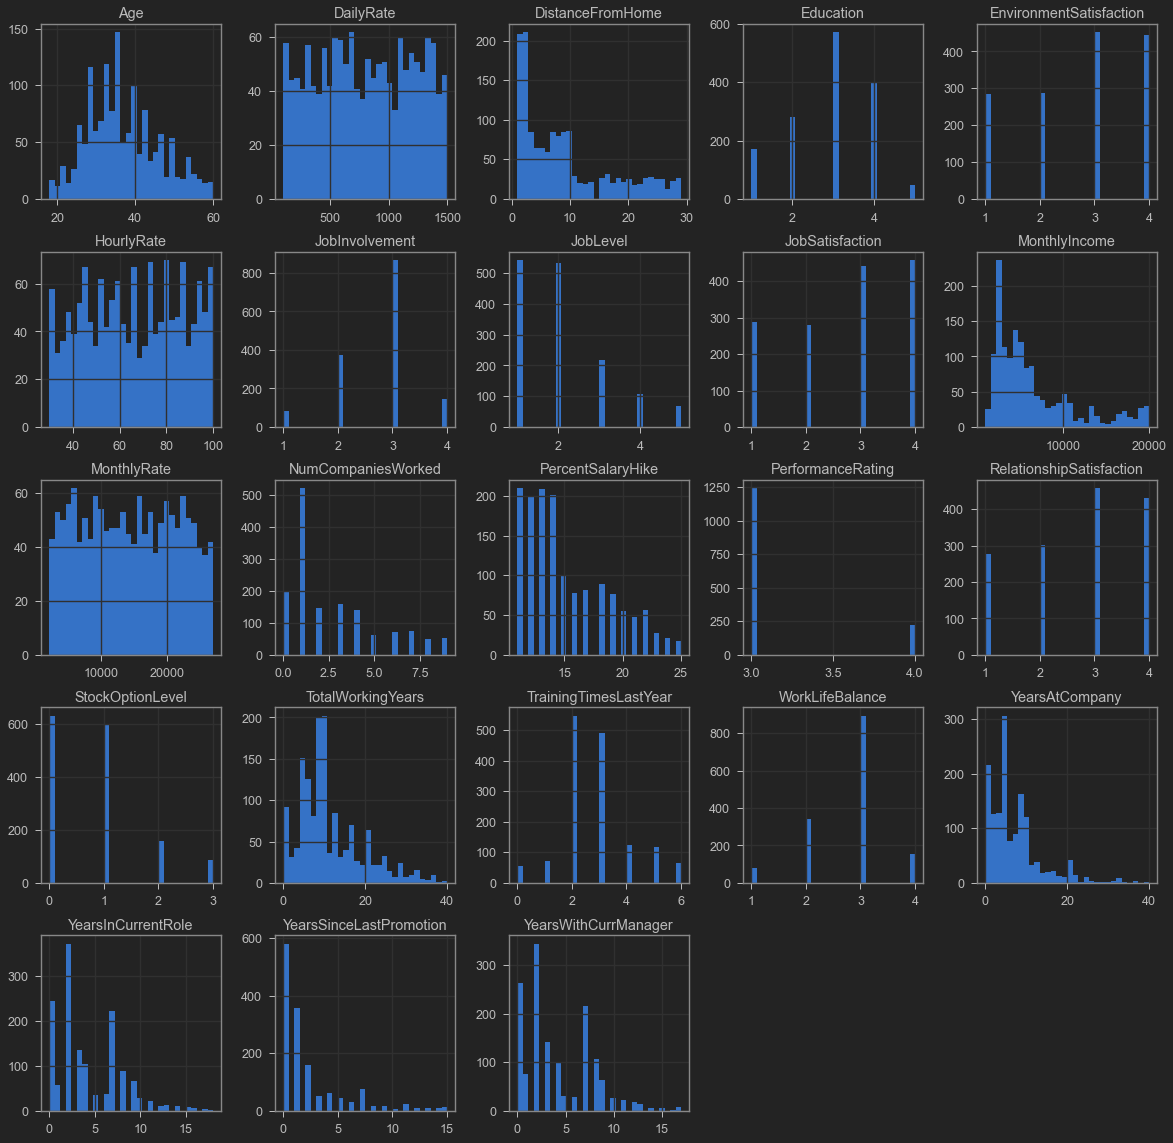

In [5]:
hr_df.hist(bins=30, figsize=(20,20), color='b');

## Data Preprocessing

Before we begin our data preprocessing, we can use a correlation matrix to visualize the relationship between our features.

<AxesSubplot:>

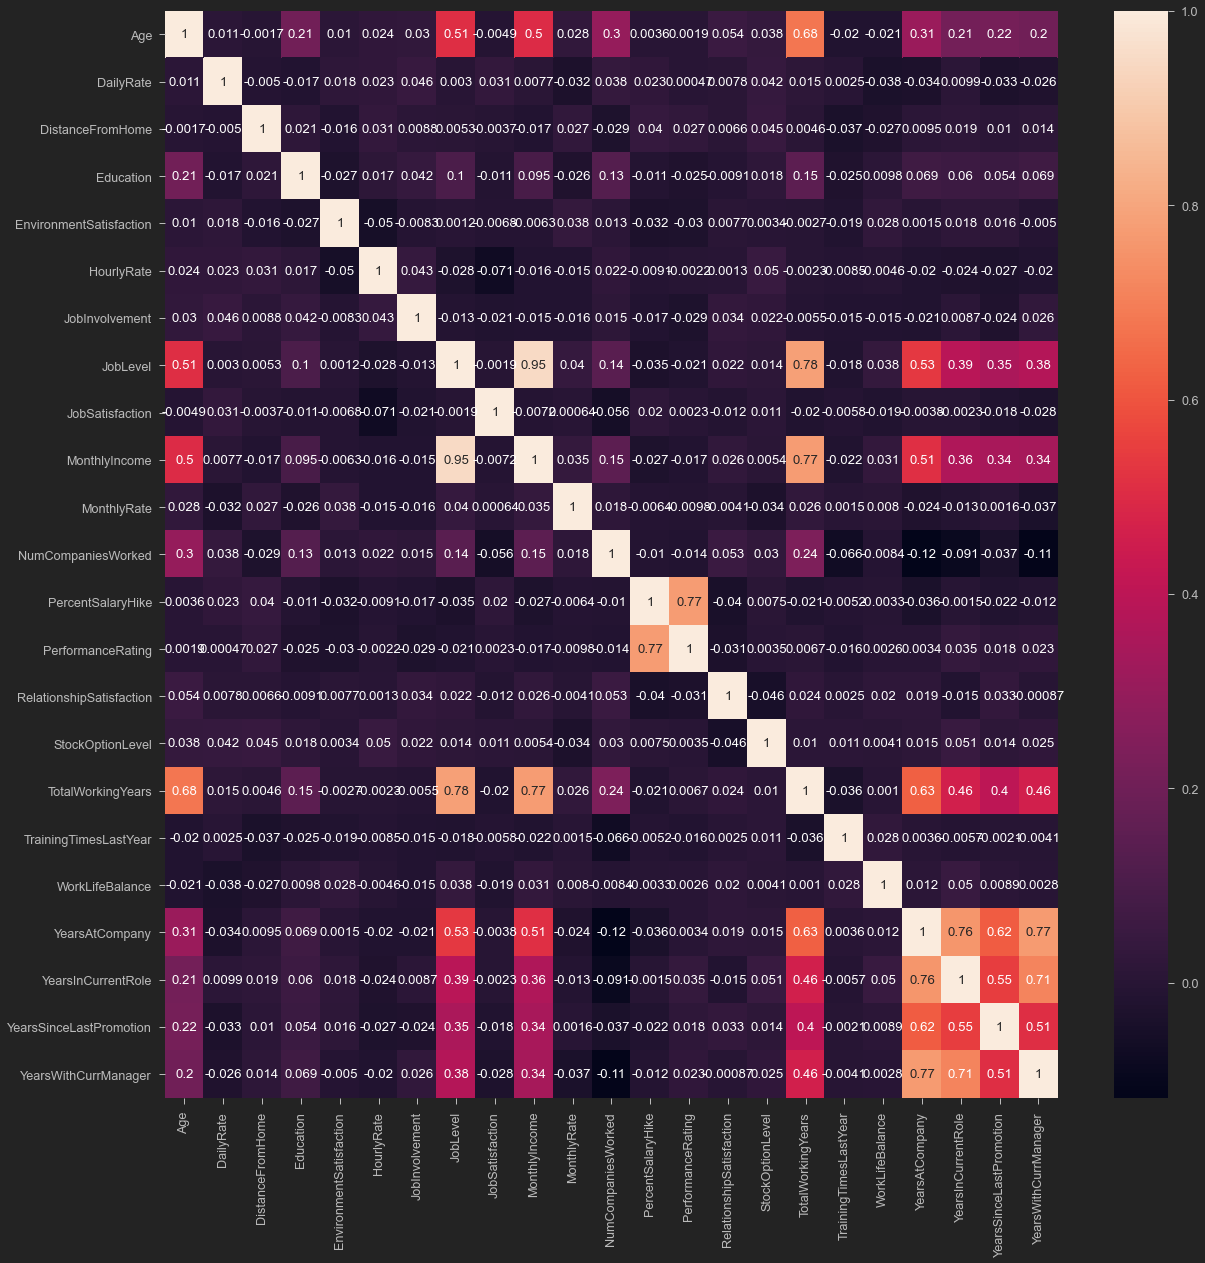

In [6]:
corr_df = hr_df.corr()
f, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr_df, 
            xticklabels=corr_df.columns,
            yticklabels=corr_df.columns,
           annot=True)

After analyzing the correlation matrix, we can see that Monthly Income and Job Level are highly correlated (0.95). 

We will need to eliminate one to reduce multicolinearity. Since Monthly Income provides greater nuance, we will drop Job Level from the dataframe.

-----

In [7]:
hr_df = hr_df.drop(columns=['JobLevel'])
hr_df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,3,Sales Executive,4,Single,5993,19479,8,Yes,11,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,2,Research Scientist,2,Married,5130,24907,1,No,23,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,2,Laboratory Technician,3,Single,2090,2396,6,Yes,15,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,56,3,Research Scientist,3,Married,2909,23159,1,Yes,11,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,40,3,Laboratory Technician,2,Married,3468,16632,9,No,12,3,4,1,6,3,3,2,2,2,2


-----

We will now encode our dependent features, which will be <b>Attrition</b> and <b>OverTime</b>.

In [8]:
hr_df['Attrition'] = np.where(hr_df['Attrition'] == 'Yes', 1, 0)
hr_df['OverTime'] = np.where(hr_df['OverTime'] == 'Yes', 1, 0)

-----

As previously mentioned, we will need to create dummies for the categorical and ranking-based features in our dataframe so that each output can have its own dedicated column. This will allow us to build our models and conduct our Survival Analysis in an efficient manner.

In [9]:
biz_travel_dummies = pd.get_dummies(hr_df['BusinessTravel'], prefix='BusinessTravel')
dep_dummies = pd.get_dummies(hr_df['Department'], prefix='Department')
edu_dummies = pd.get_dummies(hr_df['Education'], prefix='Education')
edu_field_dummies = pd.get_dummies(hr_df['EducationField'], prefix='EducationField')
env_satisfy_dummies = pd.get_dummies(hr_df['EnvironmentSatisfaction'], prefix='EnvironmentSatisfaction')
gender_dummies = pd.get_dummies(hr_df['Gender'], prefix='Gender')
job_involve_dummies = pd.get_dummies(hr_df['JobInvolvement'], prefix='JobInvolvement')
job_role_dummies = pd.get_dummies(hr_df['JobRole'], prefix='JobRole')
job_satisfy_dummies = pd.get_dummies(hr_df['JobSatisfaction'], prefix='JobSatisfaction')
marital_dummies = pd.get_dummies(hr_df['MaritalStatus'], prefix='MaritalStatus')
overtime_dummies = pd.get_dummies(hr_df['OverTime'], prefix='OverTime')
perf_dummies = pd.get_dummies(hr_df['PerformanceRating'], prefix='PerformanceRating')
rel_dummies = pd.get_dummies(hr_df['RelationshipSatisfaction'], prefix='RelationshipSatisfaction')
stock_dummies = pd.get_dummies(hr_df['StockOptionLevel'], prefix='StockOptionLevel')
work_dummies = pd.get_dummies(hr_df['WorkLifeBalance'], prefix='WorkLifeBalance')

X_categ = pd.concat([biz_travel_dummies, dep_dummies, edu_dummies, edu_field_dummies, 
                      env_satisfy_dummies, gender_dummies, job_involve_dummies, 
                      job_role_dummies, job_satisfy_dummies, marital_dummies, 
                      overtime_dummies, perf_dummies, rel_dummies, stock_dummies, 
                      work_dummies], axis=1)
X_categ.head()

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,Education_1,Education_2,Education_3,Education_4,Education_5,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,EnvironmentSatisfaction_1,EnvironmentSatisfaction_2,EnvironmentSatisfaction_3,EnvironmentSatisfaction_4,Gender_Female,Gender_Male,JobInvolvement_1,JobInvolvement_2,JobInvolvement_3,JobInvolvement_4,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,JobSatisfaction_1,JobSatisfaction_2,JobSatisfaction_3,JobSatisfaction_4,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_0,OverTime_1,PerformanceRating_3,PerformanceRating_4,RelationshipSatisfaction_1,RelationshipSatisfaction_2,RelationshipSatisfaction_3,RelationshipSatisfaction_4,StockOptionLevel_0,StockOptionLevel_1,StockOptionLevel_2,StockOptionLevel_3,WorkLifeBalance_1,WorkLifeBalance_2,WorkLifeBalance_3,WorkLifeBalance_4
0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0
1,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0
2,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0
3,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0
4,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0


These categorical and ranking-based dummies can be included with the original columns under the <b>X_categ</b> dataframe.

Next we will define our numeric features into a dataset which we will call <b>X_numeric</b>.

In [10]:
X_numeric=hr_df[['Age', 'DailyRate', 'DistanceFromHome', 'Education','EnvironmentSatisfaction', 'HourlyRate','JobInvolvement', 'JobSatisfaction', 'MonthlyIncome',
                       'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel',
                      'TotalWorkingYears', 'TrainingTimesLastYear','WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager' ]]

Since we have defined both our <b>X_categ</b> (including categorical and ranking-based features with dummies) and our <b>X_numeric</b> (including numerical features with dummies) dataframes, we can now concatenate both of these dataframes into a final dataframe which we will call <b>X_final</b>.

In [11]:
X_final=pd.concat([X_categ, X_numeric], axis=1)
X_final.head()

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,Education_1,Education_2,Education_3,Education_4,Education_5,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,EnvironmentSatisfaction_1,EnvironmentSatisfaction_2,EnvironmentSatisfaction_3,EnvironmentSatisfaction_4,Gender_Female,Gender_Male,JobInvolvement_1,JobInvolvement_2,JobInvolvement_3,JobInvolvement_4,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,JobSatisfaction_1,JobSatisfaction_2,JobSatisfaction_3,JobSatisfaction_4,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_0,OverTime_1,PerformanceRating_3,PerformanceRating_4,RelationshipSatisfaction_1,RelationshipSatisfaction_2,RelationshipSatisfaction_3,RelationshipSatisfaction_4,StockOptionLevel_0,StockOptionLevel_1,StockOptionLevel_2,StockOptionLevel_3,WorkLifeBalance_1,WorkLifeBalance_2,WorkLifeBalance_3,WorkLifeBalance_4,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,41,1102,1,2,2,94,3,4,5993,19479,8,1,11,3,1,0,8,0,1,6,4,0,5
1,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,49,279,8,1,3,61,2,2,5130,24907,1,0,23,4,4,1,10,3,3,10,7,1,7
2,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,37,1373,2,2,4,92,2,3,2090,2396,6,1,15,3,2,0,7,3,3,0,0,0,0
3,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,33,1392,3,4,4,56,3,3,2909,23159,1,1,11,3,3,0,8,3,3,8,7,3,0
4,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,27,591,2,1,1,40,3,2,3468,16632,9,0,12,3,4,1,6,3,3,2,2,2,2


We now have our final dataset which includes all of our preprocessing.

Next we can begin our <b>Clustering</b>, <b>Prediction model</b>, and <b>Survival Analysis</b>.

-----

# General Approach:

## 1. Identifying the Clusters

Using K-Means Clustering as an Unsupervised Model to segment the employees in our dataset.

## 2. Prediction Model

Using Random Forest as a Supervised Model to predict which employees will experience attrition within the company as well as which features in our dataset are most important.

## 3. Survival Analysis

Using Survival Analysis to determine which clusters of employees are most likely to survive and which clusters of employees are least likely to survive. We can use our top features along with a couple of other columns to determine this.

-----

## 1. Identifying the Clusters:

### Finding the optimal number of clusters using the "Elbow method"

In order to determine how many clusters we should segment the employees into, we can use the Elbow Method.

First we will need to scale our <b>X_final</b> dataframe in order to optimize the K-Means clustering algorithm.

### Scaling and Transforming Data

In [12]:
scaler=StandardScaler()
X_final_scaled=scaler.fit_transform(X_final)

The scaled dataset is now defined as <b>X_final_scaled</b>.

### Using the Elbow Method to determine Clusters

We will use our <b>X_final_scaled</b> to develop an 'Elbow Method' K-Means plot.

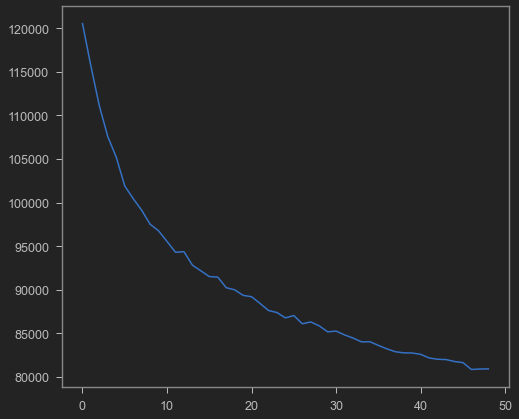

In [13]:
scores=[]
range_val=range(1,50)
for i in range_val:
    kmeans=KMeans(n_clusters=i)
    kmeans.fit(X_final_scaled)
    scores.append(kmeans.inertia_)
plt.plot(scores,'bx-')

Based on the inertia of this K-Means plot, we can see an elbow forming around 10 clusters. For the purpose of this study, we have rounded this value to the 10 cluster mark.

Now that we have the amount of clusters that we will use for the K-Means algorithm, we can proceed with the segmentation of the employees in our dataframe using clustering.

### Applying K-Means Method

We will apply the K-Means algorithm to our <b>X_final_scaled</b> dataframe with the parameter of 10 clusters.

In [14]:
kmeans=KMeans(10)
kmeans.fit(X_final_scaled)
labels=kmeans.labels_

In [15]:
cluster_centers=pd.DataFrame(data=kmeans.cluster_centers_,columns=[X_final.columns])
cluster_centers.head()

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,Education_1,Education_2,Education_3,Education_4,Education_5,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,EnvironmentSatisfaction_1,EnvironmentSatisfaction_2,EnvironmentSatisfaction_3,EnvironmentSatisfaction_4,Gender_Female,Gender_Male,JobInvolvement_1,JobInvolvement_2,JobInvolvement_3,JobInvolvement_4,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,JobSatisfaction_1,JobSatisfaction_2,JobSatisfaction_3,JobSatisfaction_4,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_0,OverTime_1,PerformanceRating_3,PerformanceRating_4,RelationshipSatisfaction_1,RelationshipSatisfaction_2,RelationshipSatisfaction_3,RelationshipSatisfaction_4,StockOptionLevel_0,StockOptionLevel_1,StockOptionLevel_2,StockOptionLevel_3,WorkLifeBalance_1,WorkLifeBalance_2,WorkLifeBalance_3,WorkLifeBalance_4,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,-0.061802,-0.108940,0.135048,-0.074453,0.260703,-0.237003,-0.035896,-0.099199,-0.000465,0.031448,0.207011,-0.136788,0.093630,-0.147023,0.157588,-0.091765,-0.119768,0.161464,-0.072080,-0.035727,-0.040631,0.133248,-0.133248,-0.003930,-0.043565,0.098451,-0.095925,-0.166540,-0.191498,-0.426008,1.694574,-0.144491,1.413185,-0.497873,-0.500389,-0.244625,0.029527,0.151585,0.056065,-0.209247,0.082943,0.154348,-0.238854,0.073244,-0.073244,0.233704,-0.233704,-0.125132,0.039800,-0.059392,0.132347,-0.109606,0.220879,-0.077971,-0.128724,-0.209291,-0.011448,0.092758,0.023020,1.114008,0.004942,-0.114587,0.146095,-0.107624,0.048070,-0.010839,-0.163234,2.104878,0.133783,0.236879,-0.073244,-0.252768,-0.233704,0.131307,-0.035207,1.811291,-0.043655,0.151268,1.571373,1.027674,1.060558,0.966187
1,-0.077657,0.120613,-0.052116,-0.211604,0.727775,-0.659960,0.064038,0.044667,-0.143050,0.074079,-0.006974,-0.136788,0.055960,-0.348255,0.154459,0.167575,-0.039392,-0.157817,0.048997,-0.009742,0.103070,0.017099,-0.017099,0.004892,-0.020712,-0.040256,0.093169,0.238504,-0.191498,0.183428,-0.231852,0.178394,-0.055266,0.486322,-0.533821,-0.244625,0.084966,-0.165077,0.052179,0.015379,0.044215,0.037367,-0.079348,-1.591746,1.591746,0.426230,-0.426230,-0.038360,-0.030666,-0.007217,0.067458,0.000137,-0.015350,-0.008946,0.043870,-0.239904,0.065583,0.064018,-0.015081,-0.084533,0.038254,0.043433,-0.027455,0.139632,-0.016285,0.048454,0.004003,-0.290858,0.048407,0.001257,1.591746,-0.349192,-0.426230,0.067628,0.020710,-0.204898,-0.031158,0.108281,-0.215905,-0.152919,-0.167179,-0.195980
2,0.031376,-0.009768,-0.012506,-0.211604,0.727775,-0.659960,0.011209,-0.037876,0.038102,0.022552,-0.097163,-0.136788,0.100142,-0.348255,0.065640,0.092116,0.089506,0.007489,-0.046205,0.032299,0.000968,-0.054957,0.054957,0.005328,-0.055820,0.011546,0.058620,0.240695,-0.191498,0.415833,-0.273059,0.301237,-0.205995,0.282972,-0.533821,-0.244625,0.008558,-0.063899,0.074005,-0.026424,0.491653,0.231332,-0.685565,0.628241,-0.628241,0.426230,-0.426230,0.001809,0.117976,-0.001524,-0.104764,-0.867229,0.498104,0.360795,0.312525,-0.239904,0.155856,-0.023201,-0.000771,-0.181601,0.089893,-0.015213,-0.016381,0.011757,0.082761,0.055248,0.005482,-0.410144,-0.071306,0.007345,-0.628241,-0.311667,-0.426230,-0.089616,0.806413,-0.265880,0.039323,0.060350,-0.194129,-0.120639,-0.140668,-0.07

### Applying Inverse Transformation to Understand the Numbers

In [16]:
cluster_centers=scaler.inverse_transform(cluster_centers)
cluster_centers=pd.DataFrame(data=cluster_centers,columns=[X_final.columns])
cluster_centers.head()

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,Education_1,Education_2,Education_3,Education_4,Education_5,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,EnvironmentSatisfaction_1,EnvironmentSatisfaction_2,EnvironmentSatisfaction_3,EnvironmentSatisfaction_4,Gender_Female,Gender_Male,JobInvolvement_1,JobInvolvement_2,JobInvolvement_3,JobInvolvement_4,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,JobSatisfaction_1,JobSatisfaction_2,JobSatisfaction_3,JobSatisfaction_4,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_0,OverTime_1,PerformanceRating_3,PerformanceRating_4,RelationshipSatisfaction_1,RelationshipSatisfaction_2,RelationshipSatisfaction_3,RelationshipSatisfaction_4,StockOptionLevel_0,StockOptionLevel_1,StockOptionLevel_2,StockOptionLevel_3,WorkLifeBalance_1,WorkLifeBalance_2,WorkLifeBalance_3,WorkLifeBalance_4,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,0.083333,0.145833,0.770833,2.777778e-02,0.777778,1.944444e-01,0.104167,0.152778,0.388889,0.284722,0.069444,1.734723e-17,0.458333,6.250000e-02,0.388889,0.034722,0.055556,0.256944,0.166667,0.291667,0.284722,0.465278,0.534722,0.055556,0.236111,0.638889,0.069444,0.041667,2.775558e-17,0.013889,5.000000e-01,0.055556,0.375000,1.387779e-16,1.388889e-02,-2.775558e-17,0.208333,0.250000,0.326389,0.215278,2.569444e-01,0.534722,2.083333e-01,7.500000e-01,2.500000e-01,0.930556,6.944444e-02,0.138889,0.222222,0.284722,0.354167,3.750000e-01,5.138889e-01,8.333333e-02,2.777778e-02,6.944444e-03,2.291667e-01,6.527778e-01,1.111111e-01,47.097222,804.479167,8.263889,3.062500,2.604167,66.868056,2.722222,2.548611,16409.236111,15265.020833,3.284722,2.500000e-01,14.284722,3.069444,2.854167,7.638889e-01,25.368056,2.743056,2.868056,16.631944,7.951389,5.604167,7.569444
1,0.078534,0.235602,0.685864,-6.938894e-18,1.000000,0.000000e+00,0.136126,0.209424,0.319372,0.303665,0.031414,1.734723e-17,0.439791,-4.163336e-17,0.387435,0.094241,0.078534,0.130890,0.214660,0.303665,0.350785,0.408377,0.591623,0.057592,0.246073,0.570681,0.125654,0.157068,2.775558e-17,0.246073,1.047120e-02,0.151832,0.041885,3.926702e-01,5.551115e-17,-5.551115e-17,0.230366,0.125654,0.324607,0.319372,2.408377e-01,0.476440,2.827225e-01,3.330669e-16,1.000000e+00,1.000000,-1.942890e-16,0.172775,0.193717,0.308901,0.324607,4.293194e-01,3.979058e-01,1.047120e-01,6.806283e-02,-7.632783e-17,2.617801e-01,6.387435e-01,9.947644e-02,36.151832,817.916230,9.544503,2.884817,2.874346,65.560209,2.764398,2.732984,5134.052356,14657.539267,2.696335,1.000000e+00,13.931937,3.000000,2.785340,8.115183e-01,9.685864,2.759162,2.837696,5.685864,3.675393,1.649215,3.424084
2,0.111538,0.184615,0.703846,0.000000e+00,1.000000,-5.551115e-17,0.119231,0.176923,0.407692,0.280769,0.015385,1.734723e-17,0.461538,-6.938894e-17,0.346154,0.076923,0.115385,0.196154,0.176923,0.323077,0.303846,0.373077,0.626923,0.057692,0.230769,0.596154,0.115385,0.157692,2.775558e-17,0.334615,-2.775558e-17,0.188462,0.007692,3.115385e-01,5.551115e-17,-6.245005e-17,0.200000,0.165385,0.334615,0.300000,4.269231e-01,0.573077,4.996004e-16,1.000000e+00,1.665335e-16,1.000000,-2.498002e-16,0.188462,0.253846,0.311538,0.246154,3.885781e-16,6.500000e-01,2.192308e-01,1.307692e-01,-1.040834e-16,3.000000e-01,5.961538e-01,1.038462e-01,35.265385,8

### Concatenating Cluster Labels to Dataset

We will want to concatenate the cluster labels to our dataframe which we will now define as <b>df_cluster</b>. This will allow us to display which cluster each employee belongs. This new cluster labeled column can be found appended at the end of this dataframe.

In [17]:
df_cluster=pd.concat([X_final,pd.DataFrame({'Cluster':labels})], axis=1)
df_cluster.head(10)

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,Education_1,Education_2,Education_3,Education_4,Education_5,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,EnvironmentSatisfaction_1,EnvironmentSatisfaction_2,EnvironmentSatisfaction_3,EnvironmentSatisfaction_4,Gender_Female,Gender_Male,JobInvolvement_1,JobInvolvement_2,JobInvolvement_3,JobInvolvement_4,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,JobSatisfaction_1,JobSatisfaction_2,JobSatisfaction_3,JobSatisfaction_4,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_0,OverTime_1,PerformanceRating_3,PerformanceRating_4,RelationshipSatisfaction_1,RelationshipSatisfaction_2,RelationshipSatisfaction_3,RelationshipSatisfaction_4,StockOptionLevel_0,StockOptionLevel_1,StockOptionLevel_2,StockOptionLevel_3,WorkLifeBalance_1,WorkLifeBalance_2,WorkLifeBalance_3,WorkLifeBalance_4,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Cluster
0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,41,1102,1,2,2,94,3,4,5993,19479,8,1,11,3,1,0,8,0,1,6,4,0,5,3
1,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,49,279,8,1,3,61,2,2,5130,24907,1,0,23,4,4,1,10,3,3,10,7,1,7,9
2,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,37,1373,2,2,4,92,2,3,2090,2396,6,1,15,3,2,0,7,3,3,0,0,0,0,1
3,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,33,1392,3,4,4,56,3,3,2909,23159,1,1,11,3,3,0,8,3,3,8,7,3,0,1
4,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,27,591,2,1,1,40,3,2,3468,16632,9,0,12,3,4,1,6,3,3,2,2,2,2,2
5,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,32,1005,2,2,4,79,3,4,3068,11864,0,0,13,3,3,0,8,2,2,7,7,3,6,4
6,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,1,0,0,59,1324,3,3,3,81,4,1,2670,9964,4,1,20,4,1,3,12,3,2,1,0,0,0,9
7,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,30,1358,24,1,4,67,3,3,2693,13335,1,0,22,4,2,1,1,2,3,1,0,0,0,9
8,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,38,216,23,3,4,44,2,3,9526,8787,0,0,21,4,2,0,10,2,3,9,7,1,8,9
9,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,36,1299,27,3,3,94,3,3,5237,16577,6,0,13,3,2,2,17,3,2,7,7,7,7,2


## 2. Random Forest Prediction Modeling:

### Scaling the Data

Now that the clustering has been achieved, we can begin constructing the <b>Random Forest</b> machine learning model. We will scale only the continuous values in the dataframe and will not scale the categorical values.

Scaling will involve the continuous valued columns in our original dataset, <b>hr_df</b>, and will be concatenated with the <b>Attrition</b> column to be included with continuous data. This is important since the Attrition column is essentially our target variable.

In [18]:
cont_cols = ['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 
           'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear',
           'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
cat_cols = ['BusinessTravel', 'Department', 'Education', 'EducationField', 'EnvironmentSatisfaction', 
           'Gender', 'JobInvolvement', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'OverTime', 
           'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']
ss = StandardScaler()
hr_scaled_df = ss.fit_transform(hr_df[cont_cols].to_numpy())

hr_scaled_df = pd.concat([pd.DataFrame(hr_scaled_df, columns=cont_cols), 
                          hr_df[cat_cols], 
                          hr_df['Attrition']], axis=1)
hr_scaled_df.head()

,Age,DailyRate,DistanceFromHome,HourlyRate,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel,Department,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,JobRole,JobSatisfaction,MaritalStatus,OverTime,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,WorkLifeBalance,Attrition
0,0.446350,0.742527,-1.010909,1.383138,-0.108350,0.726020,2.125136,-1.150554,-0.421642,-2.171982,-0.164613,-0.063296,-0.679146,0.245834,Travel_Rarely,Sales,2,Life Sciences,2,Female,3,Sales Executive,4,Single,1,3,1,0,1,1
1,1.322365,-1.297775,-0.147150,-0.240677,-0.291719,1.488876,-0.678049,2.129306,-0.164511,0.155707,0.488508,0.764998,-0.368715,0.806541,Travel_Frequently,Research & Development,1,Life Sciences,3,Male,2,Research Scientist,2,Married,0,4,4,1,3,0
2,0.008343,1.414363,-0.887515,1.284725,-0.937654,-1.674841,1.324226,-0.057267,-0.550208,0.155707,-1.144294,-1.167687,-0.679146,-1.155935,Travel_Rarely,Research & Development,2,Other,4,Male,2,Laboratory Technician,3,Single,1,3,2,0,3,1
3,-0.429664,1.461466,-0.764121,-0.486709,-0.763634,1.243211,-0.678049,-1.150554,-0.421642,0.155707,0.161947,0.764998,0.252146,-1.155935,Travel_Frequently,Research & Development,4,Life Sciences,4,Female,3,Research Scientist,3,Married,1,3,3,0,3,0
4,-1.086676,-0.524295,-0.887515,-1.274014,-0.644858,0.325900,2.525591,-0.877232,-0.678774,0.155707,-0.817734,-0.615492,-0.058285,-0.595227,Travel_Rarely,Research & Development,1,Medical,1,Male,3,Laboratory Technician,2,Married,0,3,4,1,3,0


### Balancing the Data

Since we are using the scaled original dataset, <b>hr_scaled_df</b>, we will now need to balance the dataset before we can finish the construction of the Random Forest model.

To achieve this, we will use <b>SMOTE</b> to balance the data.

In [19]:
dependent_df = hr_scaled_df['Attrition']
independent_df = hr_scaled_df.drop(columns=['Attrition'])
sm = SMOTENC(
    categorical_features=[independent_df.columns.get_loc(col) for col in cat_cols],
    sampling_strategy='auto', 
    k_neighbors=8, 
    random_state=42)
independent_resample, dependent_resample = sm.fit_resample(independent_df, dependent_df)
smoted_df = pd.concat([pd.DataFrame(independent_resample), pd.DataFrame(dependent_resample)], axis=1)
smoted_df

,Age,DailyRate,DistanceFromHome,HourlyRate,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel,Department,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,JobRole,JobSatisfaction,MaritalStatus,OverTime,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,WorkLifeBalance,Attrition
0,0.446350,0.742527,-1.010909,1.383138,-0.108350,0.726020,2.125136,-1.150554,-0.421642,-2.171982,-0.164613,-0.063296,-0.679146,0.245834,Travel_Rarely,Sales,2,Life Sciences,2,Female,3,Sales Executive,4,Single,1,3,1,0,1,1
1,1.322365,-1.297775,-0.147150,-0.240677,-0.291719,1.488876,-0.678049,2.129306,-0.164511,0.155707,0.488508,0.764998,-0.368715,0.806541,Travel_Frequently,Research & Development,1,Life Sciences,3,Male,2,Research Scientist,2,Married,0,4,4,1,3,0
2,0.008343,1.414363,-0.887515,1.284725,-0.937654,-1.674841,1.324226,-0.057267,-0.550208,0.155707,-1.144294,-1.167687,-0.679146,-1.155935,Travel_Rarely,Research & Development,2,Other,4,Male,2,Laboratory Technician,3,Single,1,3,2,0,3,1
3,-0.429664,1.461466,-0.764121,-0.486709,-0.763634,1.243211,-0.678049,-1.150554,-0.421642,0.155707,0.161947,0.764998,0.252146,-1.155935,Travel_Frequently,Research & Development,4,Life Sciences,4,Female,3,Research Scientist,3,Married,1,3,3,0,3,0
4,-1.086676,-0.524295,-0.887515,-1.274014,-0.644858,0.325900,2.525591,-0.877232,-0.678774,0.155707,-0.817734,-0.615492,-0.058285,-0.595227,Travel_Rarely,Research & Development,1,Medical,1,Male,3,Laboratory Technician,2,Married,0,3,4,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2461,-1.378159,-1.180086,-0.302229,-1.691602,-0.830399,-1.092357,-0.780877,-0.393363,-1.255576,0.155707,-0.939088,-1.025896,-0.368715,-1.155935,Travel_Rarely,Sales,3,Marketing,4,Female,3,Sales Representative,3,Single,0,3,2,0,3,1
2462,0.839179,-0.885440,2.039522,-0.944745,0.862164,0.572545,0.409237,-0.681773,0.828145,-0.065325,-0.747482,-0.772797,-0.235151,-1.155935,Travel_Frequently,Sales,2,Life Sciences,2,Male,3,Sales Executive,3,Single,1,3,1,0,3,1
2463,-0.994284,0.363404,-0.441497,0.951813,-0.714668,1.009532,-0.678049,0.005367,-0.342629,-0.381764,0.262296,0.510471,-0.368715,0.289642,Travel_Rarely,Research & Development,1,Medical,3,Male,3,Laboratory Technician,4,Single,0,3,1,0,3,1
2464,-0.076276,-0.082383,-0.911821,0.927609,-0.454489,-0.938370,0.681074,-1.042880,-0.448912,-0.620189,-0.199245,-0.343571,-0.429862,0.131148,Travel_Rarely,Research & Development,3,Life Sciences,1,Male,3,Laboratory Technician,1,Married,0,3,3,0,3,1


### Dimension Reduction

Our new balanced dataframe for our Random Forest model has been defined as <b>smoted_df</b>. For our dimension reduction, we will use the <b>Factor Analysis of Mixed Data</b> also known as <b>FAMD</b>. This will be a useful method since we do indeed have mixed data in our <b>smoted_df</b>.

We will be looking at the first 10 components for our Random Forest model. 

Using a random_state of 42 can be used as a constant for reproducability.

The Attrition column will be dropped since our Random Forest model will be trying to predict that column.

In [20]:
import prince

famd = prince.FAMD(
    n_components=10,
    n_iter=10,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=42
)

famd_fit = famd.fit(smoted_df.drop(columns=['Attrition'])) 
principle_components_df = famd_fit.transform(smoted_df.drop(columns=['Attrition']))
# smoted_df = pd.concat([smoted_df, principle_components_df], axis=1)

rename_cols = {}
#for col in principle_components_df:
#    rename_cols[col] = 'PC' + str(col + 1)

#smoted_df = smoted_df.rename(columns=rename_cols)
famd_fit.explained_inertia_

array([0.10606221, 0.0639568 , 0.05878143, 0.04283831, 0.04179815,
       0.0363634 , 0.03390717, 0.03075957, 0.02985057, 0.02804131])

As before when we were creating our clusters, we will now need to address the categorical columns that contain multiple outputs. We will take our <b>smoted_df</b>, which is balanced and has been processed using dimension reduction, and this time we will assign numerical values for the multi-output categorical columns of this dataframe.

### Assigning Numerical Values to Categorical Outputs

In [21]:
smoted_df['BusinessTravel'] = np.select([
    smoted_df['BusinessTravel'] == 'Non-Travel', 
    smoted_df['BusinessTravel'] == 'Travel_Rarely', 
    smoted_df['BusinessTravel'] == 'Travel_Frequently'], [0,1,2])

smoted_df['Department'] = np.select([
    smoted_df['Department'] == 'Human Resources', 
    smoted_df['Department'] == 'Research & Development', 
    smoted_df['Department'] == 'Sales'], [0,1,2])

smoted_df['EducationField'] = np.select([
    smoted_df['EducationField'] == 'Human Resources', 
    smoted_df['EducationField'] == 'Life Sciences', 
    smoted_df['EducationField'] == 'Marketing', 
    smoted_df['EducationField'] == 'Medical', 
    smoted_df['EducationField'] == 'Other', 
    smoted_df['EducationField'] == 'Technical Degree'], [0,1,2,3,4,5])

smoted_df['Gender'] = np.select([
    smoted_df['Gender'] == 'Male', 
    smoted_df['Gender'] == 'Female'], [0,1])

smoted_df['JobRole'] = np.select([
    smoted_df['JobRole'] == 'Healthcare Representative', 
    smoted_df['JobRole'] == 'Human Resources', 
    smoted_df['JobRole'] == 'Laboratory Technician', 
    smoted_df['JobRole'] == 'Manager', 
    smoted_df['JobRole'] == 'Manufacturing Director', 
    smoted_df['JobRole'] == 'Research Director', 
    smoted_df['JobRole'] == 'Research Scientist', 
    smoted_df['JobRole'] == 'Sales Executive', 
    smoted_df['JobRole'] == 'Sales Representative'], [0,1,2,3,4,5,6,7,8])

smoted_df['MaritalStatus'] = np.select([
    smoted_df['MaritalStatus'] == 'Single',
    smoted_df['MaritalStatus'] == 'Married',
    smoted_df['MaritalStatus'] == 'Divorced'], [0,1,2])

smoted_df.head()

,Age,DailyRate,DistanceFromHome,HourlyRate,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel,Department,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,JobRole,JobSatisfaction,MaritalStatus,OverTime,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,WorkLifeBalance,Attrition
0,0.446350,0.742527,-1.010909,1.383138,-0.108350,0.726020,2.125136,-1.150554,-0.421642,-2.171982,-0.164613,-0.063296,-0.679146,0.245834,1,2,2,1,2,1,3,7,4,0,1,3,1,0,1,1
1,1.322365,-1.297775,-0.147150,-0.240677,-0.291719,1.488876,-0.678049,2.129306,-0.164511,0.155707,0.488508,0.764998,-0.368715,0.806541,2,1,1,1,3,0,2,6,2,1,0,4,4,1,3,0
2,0.008343,1.414363,-0.887515,1.284725,-0.937654,-1.674841,1.324226,-0.057267,-0.550208,0.155707,-1.144294,-1.167687,-0.679146,-1.155935,1,1,2,4,4,0,2,2,3,0,1,3,2,0,3,1
3,-0.429664,1.461466,-0.764121,-0.486709,-0.763634,1.243211,-0.678049,-1.150554,-0.421642,0.155707,0.161947,0.764998,0.252146,-1.155935,2,1,4,1,4,1,3,6,3,1,1,3,3,0,3,0
4,-1.086676,-0.524295,-0.887515,-1.274014,-0.644858,0.325900,2.525591,-0.877232,-0.678774,0.155707,-0.817734,-0.615492,-0.058285,-0.595227,1,1,1,3,1,0,3,2,2,1,0,3,4,1,3,0


-----
### Splitting Data Into Training Set and Testing Set

The Data Preprocessing for our Random Forest model has now been complete. We can now split the data into the training set and the testing set. We will apply this to the <b>smoted_df</b> since that dataframe has all of the preprocessing already applied to it.

In [22]:
x_train, x_test, y_train, y_test = train_test_split(smoted_df.drop(columns=['Attrition']), 
                                                    smoted_df['Attrition'], 
                                                    train_size=0.7,
                                                    random_state=42) 

rand_forest_fit = RandomForestClassifier(n_estimators=1000, 
                                         criterion="gini", 
                                         max_depth=100, 
                                         min_samples_split=3, 
                                         min_samples_leaf=2) 

rand_forest_fit.fit(x_train, y_train)
print("Random Forest - Train Confusion Matrix\n", pd.crosstab(y_train, 
                                                              rand_forest_fit.predict(x_train), 
                                                              rownames=["Actual"], 
                                                              colnames=["Predicted"]))

print("Random Forest - Train accuracy", round(accuracy_score(y_train, rand_forest_fit.predict(x_train)), 3))

print("Random Forest - Test Confusion Matrix", pd.crosstab(y_test, 
                                                           rand_forest_fit.predict(x_test), 
                                                           rownames=["Actual"], 
                                                           colnames=["Predicted"]))

print("Random Forest - Test accuracy", round(accuracy_score(y_test, rand_forest_fit.predict(x_test)), 3))

Random Forest - Train Confusion Matrix
 Predicted    0    1
Actual             
0          863    1
1            5  857
Random Forest - Train accuracy 0.997
Random Forest - Test Confusion Matrix Predicted    0    1
Actual             
0          329   40
1           40  331
Random Forest - Test accuracy 0.892


--

Analyzing the confusion matrix of the model, we can see that our Random Forest model has:
- <b>Train accuracy</b> of 0.997
- <b>Test accuracy</b> of 0.892

-----

### Using Pipeline to Automate Workflow

In [23]:
pipeline = Pipeline([('clf', RandomForestClassifier(criterion='gini'))])
parameters = {
    'clf__n_estimators': (200, 300, 500),
    'clf__max_depth': (20, 30, 50),
    'clf__min_samples_split': (2, 3),
    'clf__min_samples_leaf': (1, 2)}
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, cv=5, verbose=1, scoring='accuracy')
grid_search.fit(x_train, y_train)
print('Best Training score: ' + str(grid_search.best_score_))
print('Best parameters set:')
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print(str(param_name) + ': ' + str(best_parameters[param_name]))
    
predictions = grid_search.predict(x_test)
print("Testing accuracy: " + str(accuracy_score(y_test, predictions)))
print("Complete report of Testing data", classification_report(y_test, predictions))
print("Random Forest Grid Search - Test Confusion Matrix", pd.crosstab(y_test, predictions, rownames=["Actual"], colnames=["Predicted"]))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.0min finished


Best Training score: 0.8962938761832957
Best parameters set:
clf__max_depth: 30
clf__min_samples_leaf: 1
clf__min_samples_split: 3
clf__n_estimators: 300
Testing accuracy: 0.9013513513513514
Complete report of Testing data               precision    recall  f1-score   support

           0       0.89      0.91      0.90       369
           1       0.91      0.89      0.90       371

    accuracy                           0.90       740
   macro avg       0.90      0.90      0.90       740
weighted avg       0.90      0.90      0.90       740

Random Forest Grid Search - Test Confusion Matrix Predicted    0    1
Actual             
0          336   33
1           40  331


--

We can see that our precision, recall, and F1-scores are performing very well. 

The weighted average score is 90%. 

-----

## 3. Survival Analysis

### Feature Importance for Survival Analysis

We will use the <b>rand_forest_fit</b> to print the feature ranking of our dataset. This feature ranking list will be derived from our Random Forest machine learning model.

This list will provide us with all of the features ranking in order of importance. We will use the top 10 most important features to provide us with a baseline for our Survival Analysis which will utilize our clusters.

Feature ranking:
Feature 27 , StockOptionLevel 0.17651542299887096
Feature 23 , MaritalStatus 0.05904200039637602
Feature 21 , JobRole 0.05328336551328171
Feature 24 , OverTime 0.05169568636440397
Feature 0 , Age 0.049824312999315994
Feature 4 , MonthlyIncome 0.04903082568696148
Feature 8 , TotalWorkingYears 0.04698533363678131
Feature 10 , YearsAtCompany 0.042580980573612676
Feature 13 , YearsWithCurrManager 0.04151986442315188
Feature 9 , TrainingTimesLastYear 0.0362310692950989
Feature 2 , DistanceFromHome 0.0350950621090232
Feature 11 , YearsInCurrentRole 0.03494294268099761
Feature 6 , NumCompaniesWorked 0.034538851916149124
Feature 3 , HourlyRate 0.033834517381966835
Feature 1 , DailyRate 0.03040346816271123
Feature 7 , PercentSalaryHike 0.02733730032280673
Feature 5 , MonthlyRate 0.026782890579115884
Feature 18 , EnvironmentSatisfaction 0.025715871664453598
Feature 12 , YearsSinceLastPromotion 0.024190294617387913
Feature 22 , JobSatisfaction 0.019293798939446404
Feature 16 , Ed

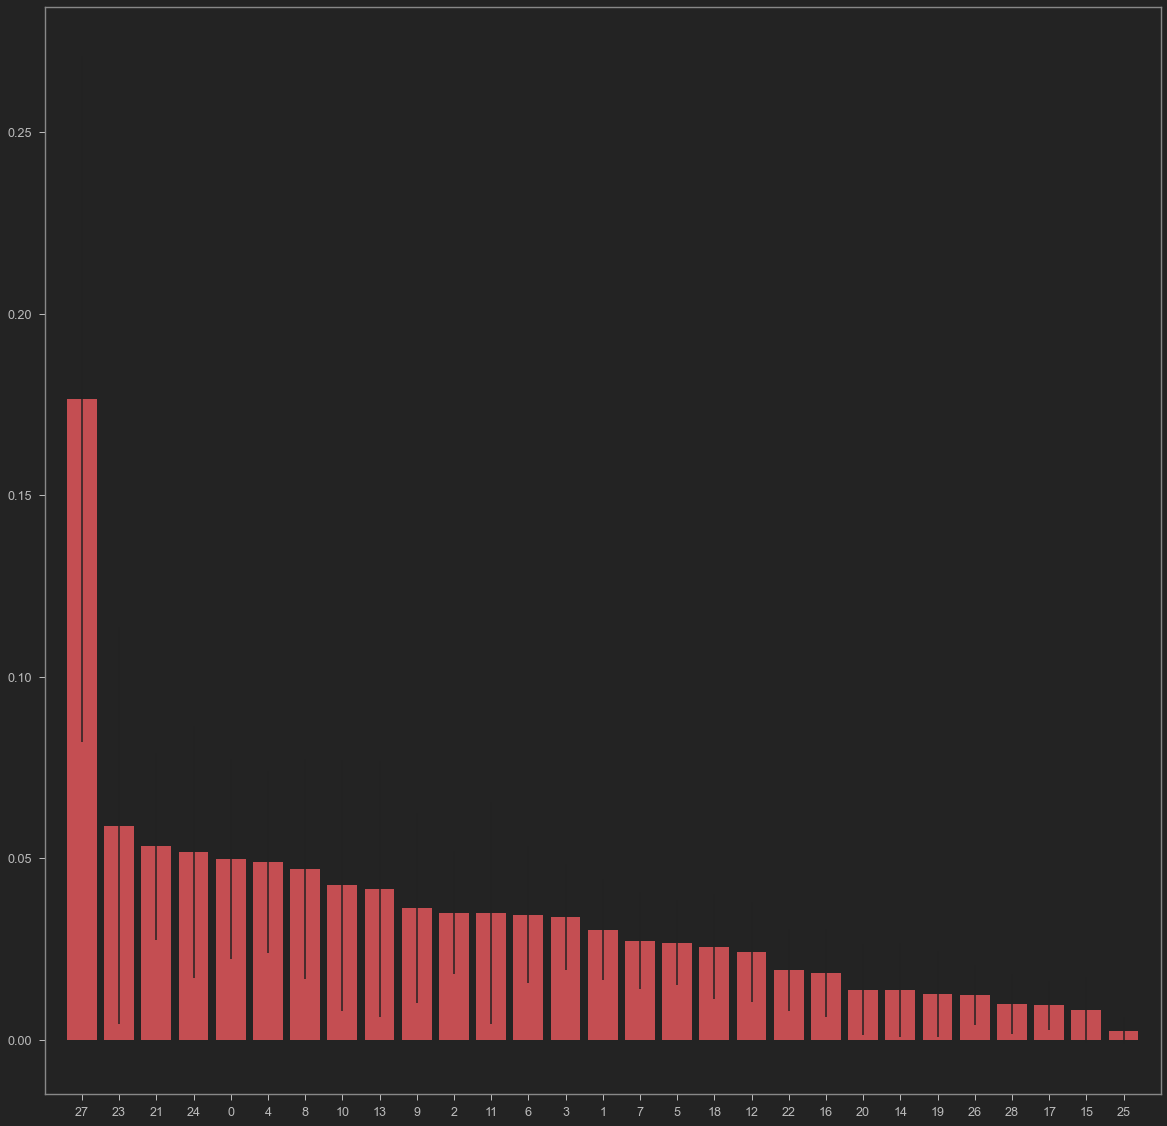

In [24]:
rand_forest_fit = RandomForestClassifier(n_estimators=500, criterion="gini", max_depth=30, min_samples_split=2, min_samples_leaf=2)
rand_forest_fit.fit(x_train, y_train)
importances = rand_forest_fit.feature_importances_
standard_deviations = np.std([tree.feature_importances_ for tree in rand_forest_fit.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
column_names = list(x_train.columns)

print("Feature ranking:")
for feature in range(x_train.shape[1]):
    print ("Feature", indices[feature], ",", column_names[indices[feature]], importances[indices[feature]])
    
plt.figure(figsize=(20,20))
plt.bar(range(x_train.shape[1]), importances[indices], color="r", yerr=standard_deviations[indices], align="center")
plt.xticks(range(x_train.shape[1]), indices)
plt.xlim([-1, x_train.shape[1]])
plt.show()

### Using top 10 features from Random Forest feature importance

We can see from the list that our top 10 most important features includes:
- Stock Option Level
- Marital Status Single
- Job Role Sales Executive
- Overtime
- Age
- Years At Company
- Monthly Income
- Total Working Years
- Years With Current Manager
- Training Time Last Year

Since we had Marital Status and Job Role listed, we decided to use <b>Marital Status Single</b> and <b>Job Role Sales Executive</b>. They were the greatest of significance out of all of the outputs for each column which is why we selected them.

In [25]:
X_important=df_cluster[['StockOptionLevel','MaritalStatus_Single', 'JobRole_Sales Executive', 'OverTime', 'Age',
                         'YearsAtCompany', 'MonthlyIncome', 'TotalWorkingYears', 'YearsWithCurrManager', 'TrainingTimesLastYear']]
X_important.head()

,StockOptionLevel,MaritalStatus_Single,JobRole_Sales Executive,OverTime,Age,YearsAtCompany,MonthlyIncome,TotalWorkingYears,YearsWithCurrManager,TrainingTimesLastYear
0,0,1,1,1,41,6,5993,8,5,0
1,1,0,0,0,49,10,5130,10,7,3
2,0,1,0,1,37,0,2090,7,0,3
3,0,0,0,1,33,8,2909,8,0,3
4,1,0,0,0,27,2,3468,6,2,3


Now that we have the dataframe with our top 10 most important features, we will need to concatenate the <b>Attrition</b> column and the <b>Cluster</b> column to the dataset.

### Creating the DataFrame for Survival Analysis

In [26]:
df_survival=pd.concat([X_important, hr_df['Attrition'], pd.DataFrame({'Cluster':labels})],axis=1)
df_survival.head()

,StockOptionLevel,MaritalStatus_Single,JobRole_Sales Executive,OverTime,Age,YearsAtCompany,MonthlyIncome,TotalWorkingYears,YearsWithCurrManager,TrainingTimesLastYear,Attrition,Cluster
0,0,1,1,1,41,6,5993,8,5,0,1,3
1,1,0,0,0,49,10,5130,10,7,3,0,9
2,0,1,0,1,37,0,2090,7,0,3,1,1
3,0,0,0,1,33,8,2909,8,0,3,0,1
4,1,0,0,0,27,2,3468,6,2,3,0,2


We can now see our complete dataframe that we will be using for Survival Analysis which now includes the Attrition and Cluster columns.

Now we will provide a bar plot to show how our duration column relates to our event column. Keep in mind that our duration column will be <b>Years At Company</b> and our event column will be <b>Attrition</b>.

<AxesSubplot:xlabel='Attrition', ylabel='YearsAtCompany'>

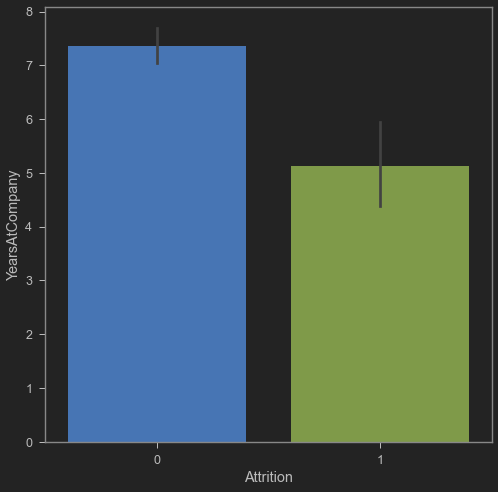

In [27]:
plt.figure(figsize=(8,8))
sns.barplot(data=df_survival, x=df_survival['Attrition'], y=df_survival['YearsAtCompany'])

In the Attrition columns, the value 0 means no and the value 1 means yes. In other words, employees that have 0 have not experienced attrition and employees that have 1 have experienced attrition.

We can see here that employees that have left the company through attrition have worked no longer than 5 years. Employees who have worked longer than 5 years tend to be still with the company.

In [29]:
df_survival.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   StockOptionLevel         1470 non-null   int64
 1   MaritalStatus_Single     1470 non-null   uint8
 2   JobRole_Sales Executive  1470 non-null   uint8
 3   OverTime                 1470 non-null   int64
 4   Age                      1470 non-null   int64
 5   YearsAtCompany           1470 non-null   int64
 6   MonthlyIncome            1470 non-null   int64
 7   TotalWorkingYears        1470 non-null   int64
 8   YearsWithCurrManager     1470 non-null   int64
 9   TrainingTimesLastYear    1470 non-null   int64
 10  Attrition                1470 non-null   int64
 11  Cluster                  1470 non-null   int32
dtypes: int32(1), int64(9), uint8(2)
memory usage: 112.1 KB


### Using the Kaplan-Meier Model

In [30]:
from lifelines import KaplanMeierFitter

In [31]:
kmf=KaplanMeierFitter()
kmf.fit(df_survival['YearsAtCompany'], df_survival['Attrition'], label='Kaplan Meier Estimate')

<lifelines.KaplanMeierFitter:"Kaplan Meier Estimate", fitted with 1470 total observations, 1233 right-censored observations>

#### The Kaplan-Meier estimator is a non-parametric estimator that allows us to use observed data to estimate the survival distribution. The curve plots the cumulative probability of survival beyond each given time period.

<AxesSubplot:xlabel='timeline'>

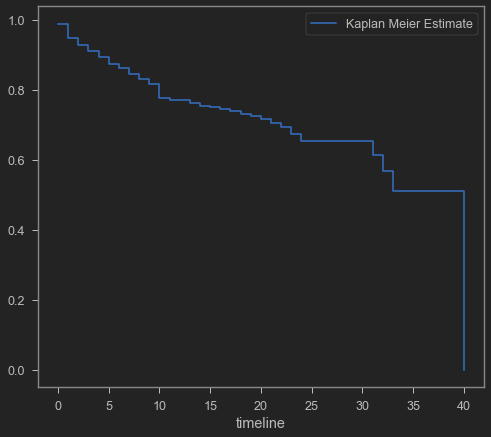

In [32]:
kmf.plot(ci_show=False)

### Plotting the Kaplan- Meier Curve per Cluster

In [33]:
clust=pd.DataFrame({'Cluster':labels})
clust_0=df_survival[df_survival['Cluster']==0]
clust_1=df_survival[df_survival['Cluster']==1]
clust_2=df_survival[df_survival['Cluster']==2]
clust_3=df_survival[df_survival['Cluster']==3]
clust_4=df_survival[df_survival['Cluster']==4]
clust_5=df_survival[df_survival['Cluster']==5]
clust_6=df_survival[df_survival['Cluster']==6]
clust_7=df_survival[df_survival['Cluster']==7]
clust_8=df_survival[df_survival['Cluster']==8]
clust_9=df_survival[df_survival['Cluster']==9]

#### The survival function measures the probability that a cluster will survive past year "t". Using the Kaplan-Meier curve allows us to visually inspect differences in survival rates by cluster category.

Text(0, 0.5, 'Survival probability')

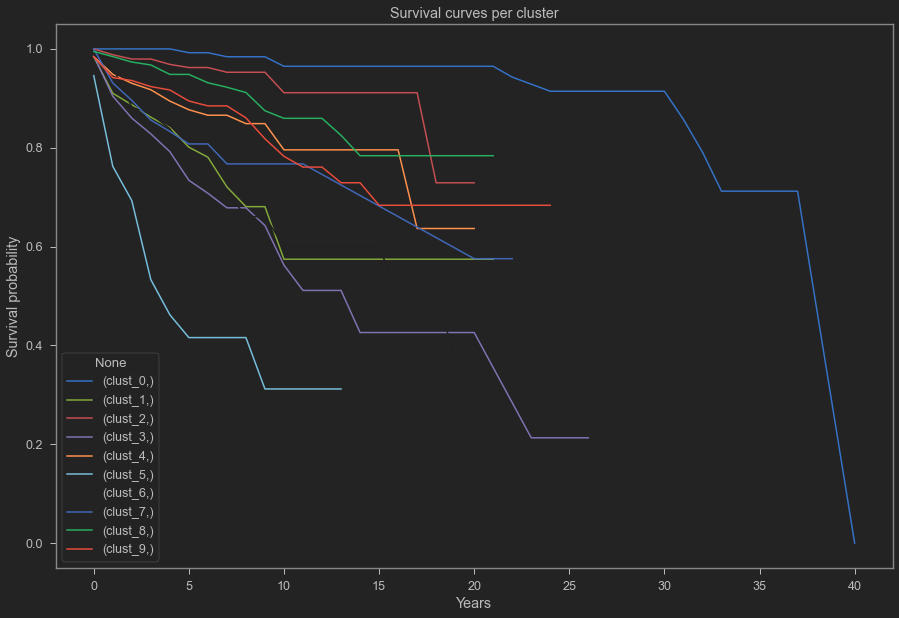

In [34]:
ax = plt.axes()
kmf.fit(clust_0['YearsAtCompany'], clust_0['Attrition'], label=['clust_0'])
kmf.survival_function_.plot(figsize=(15,10),ax=ax)
kmf.fit(clust_1['YearsAtCompany'], clust_1['Attrition'], label=['clust_1'])
kmf.survival_function_.plot(figsize=(15,10),ax=ax)
kmf.fit(clust_2['YearsAtCompany'], clust_2['Attrition'], label=['clust_2'])
kmf.survival_function_.plot(figsize=(15,10),ax=ax)
kmf.fit(clust_3['YearsAtCompany'], clust_3['Attrition'], label=['clust_3'])
kmf.survival_function_.plot(figsize=(15,10),ax=ax)
kmf.fit(clust_4['YearsAtCompany'], clust_4['Attrition'], label=['clust_4'])
kmf.survival_function_.plot(figsize=(15,10),ax=ax)
kmf.fit(clust_5['YearsAtCompany'], clust_5['Attrition'], label=['clust_5'])
kmf.survival_function_.plot(figsize=(15,10),ax=ax)
kmf.fit(clust_6['YearsAtCompany'], clust_6['Attrition'], label=['clust_6'])
kmf.survival_function_.plot(figsize=(15,10),ax=ax)
kmf.fit(clust_7['YearsAtCompany'], clust_7['Attrition'], label=['clust_7'])
kmf.survival_function_.plot(figsize=(15,10),ax=ax)
kmf.fit(clust_8['YearsAtCompany'], clust_8['Attrition'], label=['clust_8'])
kmf.survival_function_.plot(figsize=(15,10),ax=ax)
kmf.fit(clust_9['YearsAtCompany'], clust_9['Attrition'], label=['clust_9'])
kmf.survival_function_.plot(figsize=(15,10),ax=ax)

plt.title('Survival curves per cluster')
plt.xlabel('Years')
plt.ylabel('Survival probability')

### Using Cox Proportional Hazard Model

#### We can examine the confidence interval of different important features to assess its significance.

In [35]:
from lifelines import CoxPHFitter

In [36]:
cph = CoxPHFitter()

In [37]:
cph.fit(df_survival, duration_col='YearsAtCompany', event_col='Attrition')

<lifelines.CoxPHFitter: fitted with 1470 total observations, 1233 right-censored observations>

In [38]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1470 total observations, 1233 right-censored observations>
             duration col = 'YearsAtCompany'
                event col = 'Attrition'
      baseline estimation = breslow
   number of observations = 1470
number of events observed = 237
   partial log-likelihood = -1318.25
         time fit was run = 2021-03-18 02:49:38 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
StockOptionLevel         -0.15       0.86       0.12            -0.39             0.09                 0.68                 1.09
MaritalStatus_Single      0.71       2.03       0.19             0.34             1.07                 1.41                 2.92
JobRole_Sales Executive   0.07       1.07       0.19            -0.30             0.44                 0.74                 1.55
OverTime                  1.10       3.01       0.14             0.83             1.37                 2.30                 3.95
Age                      -0.01       0.99       0.01            -0.03             0.01                 0.97                 1.01
MonthlyIncome            -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
TotalWorkingYears        -0.15       0.86       0.03            -0.21            -0.10                 0.81                 0.91
YearsWithCurrManager     -0.29       0.75       0.03            -0.35            -0.24                 0.70                 0.79
TrainingTimesLastYear    -0.09       0.92       0.05            -0.19             0.02                 0.82                 1.02
Cluster                   0.04       1.05       0.03            -0.01             0.10                 0.99                 1.10

                             z      p   -log2(p)
covariate                                       
StockOptionLevel         -1.24   0.22       2.21
MaritalStatus_Single      3.78 <0.005      12.66
JobRole_Sales Executive   0.36   0.72       0.48
OverTime                  8.00 <0.005      49.54
Age                      -0.91   0.36       1.46
MonthlyIncome            -2.92 <0.005       8.15
TotalWorkingYears        -5.52 <0.005      24.78
YearsWithCurrManager    -10.03 <0.005      76.26
TrainingTimesLastYear    -1.62   0.11       3.25
Cluster                   1.71   0.09       3.51
---
Concordance = 0.89
Partial AIC = 2656.50
log-likelihood ratio test = 511.74 on 10 df
-log2(p) of ll-ratio test = 341.71

### These features are the main drivers for employees to stay at the company.

<AxesSubplot:xlabel='log(HR) (95% CI)'>

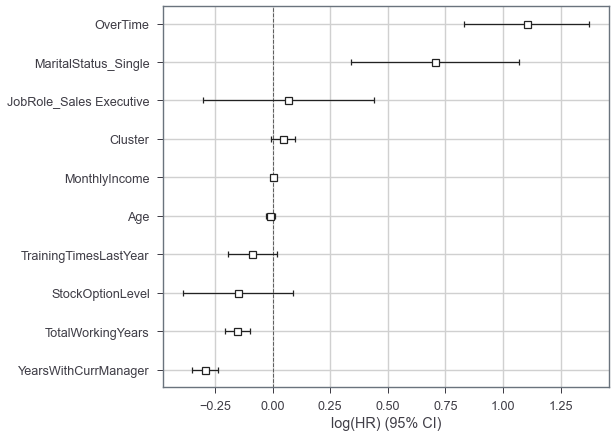

In [39]:
from jupyterthemes import jtplot
jtplot.style(theme='grade3',context='notebook',ticks=True, grid=True)
cph.plot()

### Based on p-values < 0.05 and below plot, we can see that the main significant features includes: 
- AGE
- MONTHLY INCOME
- TOTAL WORKING YEARS
- TRAINING TIMES LAST YEAR
- STOCK OPTION LEVEL
- YEARS WITH CURRENT MANAGER 

### Impact of Stock Option Levels

<AxesSubplot:>

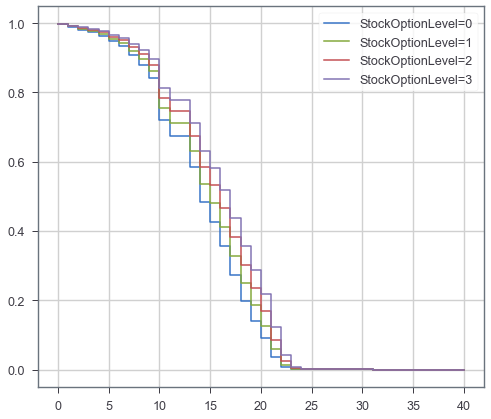

In [40]:
cph.plot_partial_effects_on_outcome('StockOptionLevel', [0,1,2,3], plot_baseline=False)

Stock Option Levels:

Level 1. Covered Call, Long Protective Puts

Level 2. Long call/put

Level 3. Spreads

Level 4. Uncovered or Naked

## Deployment

Our models can be useful for any company that has an active Human Resources division. They can implement this to determine the likelihood of employees that will leave due to attrition. This will also allow these companies to perform their own survival analysis using their own data.

Companies can also use these models to determine factors of attrition. It may also help them to elaborate strategies to retain their top employees.

## Performance Evaluation

<b>What we have done well:</b>

- Our representation of our analysis through the use of plots was effective.

- Using cluster segmentations together with the survival analysis was thorough.
    
- The App is very visually appealing and effective in determining the qualities of employees who will leave and who will stay.
    
- The inclusion of the survival analysis plot in the App was well placed since it gives us an idea of the employee clusters and the probability of each cluster's survival.

<b>What we could have done better:</b>

- Knowledge of deep learning would help us to improve our predictions.

- 

- 



## Bibliography

- https://www.investopedia.com/terms/h/humanresources.asp
- https://jobzology.com/staff-attrition-vs-staff-turnover-whats-the-difference/

## Storing the Object Data to Files for App Development

In [41]:
import os
from pathlib import Path
import pickle

pickle.dump(ss, open(Path().resolve().parent.joinpath('app').joinpath('ss.sav'), 'wb'))
pickle.dump(grid_search, open(Path().resolve().parent.joinpath('app').joinpath('grid_search.sav'), 'wb'))
pickle.dump(df_survival, open(Path().resolve().parent.joinpath('app').joinpath('survival_df.sav'), 'wb'))
pickle.dump(kmf, open(Path().resolve().parent.joinpath('app').joinpath('kmf.sav'), 'wb'))
